In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Upload Image in Colab
from google.colab import files
uploaded = files.upload()

Saving city.jpg to city.jpg


In [3]:
image_name = list(uploaded.keys())[0]
image = cv2.imread(image_name)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

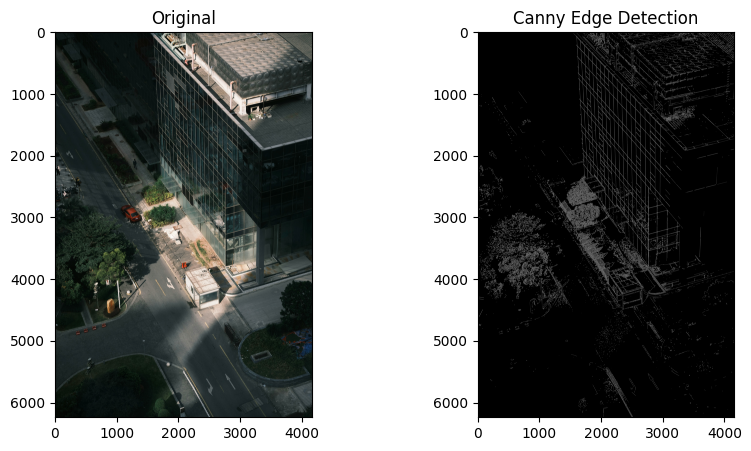

In [4]:
edges = cv2.Canny(gray, 100, 200)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(122), plt.imshow(edges, cmap="gray"), plt.title("Canny Edge Detection")
plt.show()

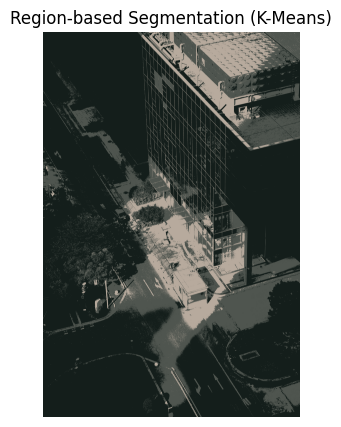

In [5]:
def segment_kmeans(image, K=3):
    img_data = image.reshape((-1, 3))
    img_data = np.float32(img_data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(img_data, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(image.shape)

    return segmented_image

segmented_img = segment_kmeans(image, K=3)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title("Region-based Segmentation (K-Means)")
plt.axis("off")
plt.show()

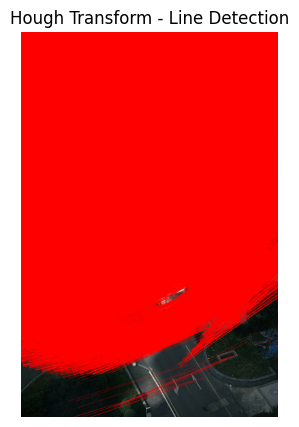

In [6]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

hough_lines_image = image.copy()
if lines is not None:
    for rho, theta in lines[:, 0]:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        cv2.line(hough_lines_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(hough_lines_image, cv2.COLOR_BGR2RGB))
plt.title("Hough Transform - Line Detection")
plt.axis("off")
plt.show()

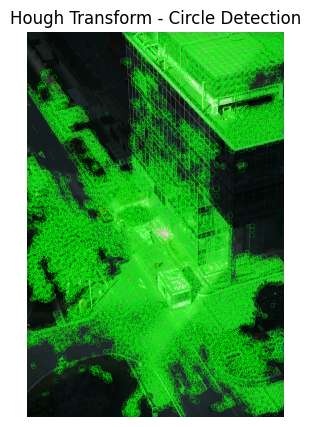

In [7]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=30, minRadius=5, maxRadius=50)

hough_circles_image = image.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(hough_circles_image, (i[0], i[1]), i[2], (0, 255, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(hough_circles_image, cv2.COLOR_BGR2RGB))
plt.title("Hough Transform - Circle Detection")
plt.axis("off")
plt.show()

In [10]:
!wget -O yolov3.cfg https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O coco.names https://github.com/pjreddie/darknet/raw/master/data/coco.names


--2025-02-19 04:26:21--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg [following]
--2025-02-19 04:26:22--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-02-19 04:26:22 (60.6 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2025-02-19 04:26:22--  https://pjreddie.com/media/files/yolov3.weight

In [11]:
import os

# Check if files exist
assert os.path.exists("yolov3.cfg"), "Error: yolov3.cfg not found!"
assert os.path.exists("yolov3.weights"), "Error: yolov3.weights not found!"
assert os.path.exists("coco.names"), "Error: coco.names not found!"

print("All YOLO files downloaded successfully!")

All YOLO files downloaded successfully!


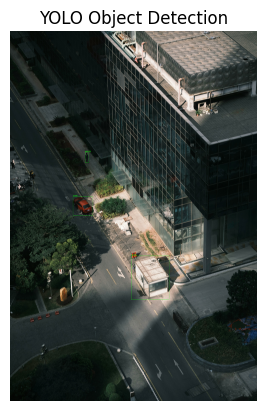

In [13]:
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load class labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load image
image = cv2.imread("city.jpg")
height, width, _ = image.shape

# Convert image to blob
blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Perform forward pass
outputs = net.forward(output_layers)

# Process detections
class_ids, confidences, boxes = [], [], []
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:
            center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply Non-Maximum Suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

for i in indices.flatten():
    x, y, w, h = boxes[i]
    label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show image
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLO Object Detection")
plt.show()

In [15]:
!wget -O faster_rcnn_inception_v2.pb https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/faster_rcnn_inception_v2.pb
!wget -O faster_rcnn_inception_v2.pbtxt https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/faster_rcnn_inception_v2.pbtxt

--2025-02-19 04:30:54--  https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/faster_rcnn_inception_v2.pb
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-19 04:30:54 ERROR 404: Not Found.

--2025-02-19 04:30:54--  https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/faster_rcnn_inception_v2.pbtxt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-02-19 04:30:55 ERROR 404: Not Found.



In [16]:
import os

# Check if files exist
assert os.path.exists("faster_rcnn_inception_v2.pb"), "Error: faster_rcnn_inception_v2.pb not found!"
assert os.path.exists("faster_rcnn_inception_v2.pbtxt"), "Error: faster_rcnn_inception_v2.pbtxt not found!"

print("Faster R-CNN model files downloaded successfully!")

Faster R-CNN model files downloaded successfully!


In [19]:
!mkdir -p model
!wget -O model/frozen_inference_graph.pb http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O model/pipeline.config https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_inception_v2.pbtxt

--2025-02-19 04:33:15--  http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.170.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149119618 (142M) [application/x-tar]
Saving to: ‘model/frozen_inference_graph.pb’

model/frozen_infere 100%[===================>] 142.21M  25.0MB/s    in 6.8s    

2025-02-19 04:33:22 (20.8 MB/s) - ‘model/frozen_inference_graph.pb’ saved [149119618/149119618]

--2025-02-19 04:33:22--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_inception_v2.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443..

In [20]:
!tar -xvzf model/frozen_inference_graph.pb -C model/

faster_rcnn_inception_v2_coco_2018_01_28/
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.index
faster_rcnn_inception_v2_coco_2018_01_28/checkpoint
faster_rcnn_inception_v2_coco_2018_01_28/pipeline.config
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt.meta
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_inception_v2_coco_2018_01_28/saved_model/variables/
faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb


In [21]:
import os

# Define correct paths
pb_model = "model/frozen_inference_graph.pb"
pb_txt = "model/pipeline.config"

# Check if files exist
assert os.path.exists(pb_model), "Error: frozen_inference_graph.pb not found!"
assert os.path.exists(pb_txt), "Error: pipeline.config not found!"

print("Faster R-CNN model files verified successfully!")

Faster R-CNN model files verified successfully!


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Faster R-CNN model with correct file paths
net = cv2.dnn.readNetFromTensorflow("model/frozen_inference_graph.pb", "model/pipeline.config")

# Load and preprocess image
image_name = "city.jpg"  # Change if needed
image = cv2.imread(image_name)

if image is None:
    print("Error: Image not found. Check the filename or upload the image.")
else:
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, size=(300, 300), swapRB=True, crop=False)
    net.setInput(blob)

    # Perform forward pass
    detections = net.forward()

    # Draw detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            (x, y, x_max, y_max) = box.astype("int")

            cv2.rectangle(image, (x, y), (x_max, y_max), (0, 255, 0), 2)

    # Display image with detections
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Faster RCNN Object Detection")
    plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/dnn/src/tensorflow/tf_io.cpp:42: error: (-2:Unspecified error) FAILED: ReadProtoFromBinaryFile(param_file, param). Failed to parse GraphDef file: model/frozen_inference_graph.pb in function 'ReadTFNetParamsFromBinaryFileOrDie'
